In [57]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os # need for file enumeration

# CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import ConfusionMatrixDisplay

# For reproducibility
np.random.seed(42)

---
##### Data Acquisition

In [2]:
# load train images
train_path = './data/seg_train/seg_train'
train_datagen = ImageDataGenerator(rescale = 1. / 255)
itr = train_datagen.flow_from_directory(
    train_path,
    target_size = (150, 150),
    batch_size = 15_000,
    class_mode = 'categorical')

X_train, y_train = itr.next()

Found 14034 images belonging to 6 classes.


In [3]:
# load validation images
val_path = './data/seg_test/seg_test'
val_datagen = ImageDataGenerator(rescale = 1. / 255)
itr = val_datagen.flow_from_directory(
    val_path,
    target_size = (150, 150),
    batch_size = 3_000,
    class_mode = 'categorical')

X_val, y_val = itr.next()

Found 3000 images belonging to 6 classes.


In [15]:
# load test images
test_path = './data/seg_pred'
test_datagen = ImageDataGenerator(rescale = 1. / 255)
itr = test_datagen.flow_from_directory(
    test_path,
    target_size = (150, 150),
    batch_size = 7_500,
    class_mode = None)

X_test = itr.next()

Found 7301 images belonging to 1 classes.


In [5]:
class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

---
##### Exploratory Data Analysis

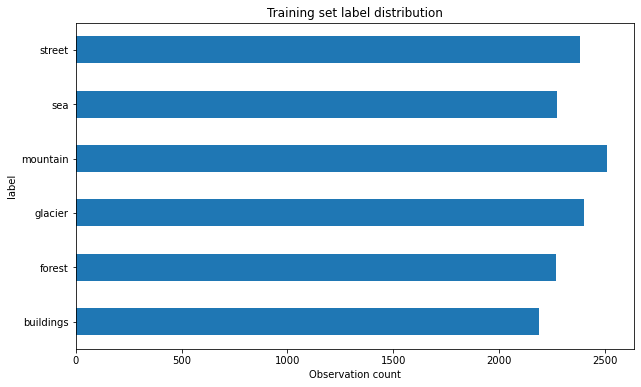

In [6]:
# how's our distribution of labels in the training set?
plt.figure(figsize = (10, 6))
plt.title('Training set label distribution')
plt.xlabel('Observation count')
train_class_labels = pd.DataFrame([class_labels[np.argmax(x)] for x in y_train], columns = ['label'])
train_class_groups = train_class_labels.groupby('label')['label'].count()
train_class_groups.plot.barh();

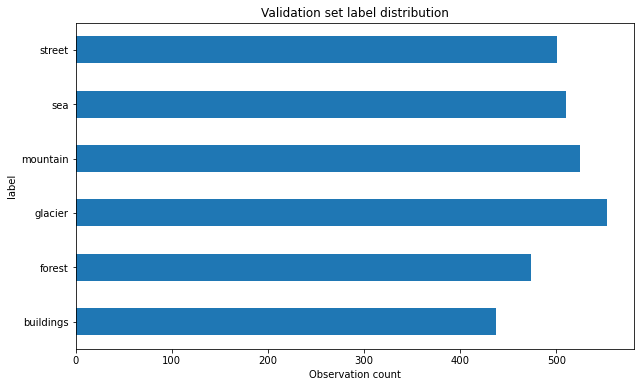

In [7]:
# how's our distribution of labels in the validation set?
plt.figure(figsize = (10, 6))
plt.title('Validation set label distribution')
plt.xlabel('Observation count')
val_class_labels = pd.DataFrame([class_labels[np.argmax(x)] for x in y_val], columns = ['label'])
val_class_groups = val_class_labels.groupby('label')['label'].count()
val_class_groups.plot.barh();

In [8]:
# quick-and-dirty auto-layout grid
# From Gabe's lab 9.2!
def display_images(images, labels, num_examples = 10, images_per_row = 4):
    '''
    Displays image data as a grid of images

    Parameters:
    - images (array): per-pixel image data
    - labels (array): corresponding labels for each image
    - num_examples (int): how many images to display, starting from element 0
    - images_per_row (int): how many images to include in each row of the display grid

    Displays:
    - auto-layout grid of requested images with labels
    '''
    total_rows = int(np.ceil(num_examples / images_per_row))
    fig, ax = plt.subplots(
        total_rows,
        images_per_row, figsize = (images_per_row * 2.5, total_rows * 2.5))
    for i in range(0, num_examples):
        row = int(i / images_per_row)
        col = i - (row * images_per_row)
        ax[row, col].axis('off')
        ax[row, col].set_title(labels[i])
        ax[row, col].imshow(images[i]);
    # delete any trailing empty subplots
    # https://stackoverflow.com/questions/44980658/remove-the-extra-plot-in-the-matplotlib-subplot
    for i in range(num_examples, total_rows * images_per_row):
        fig.delaxes(ax[total_rows - 1][i % images_per_row])
    fig.suptitle(f'First {num_examples} images');

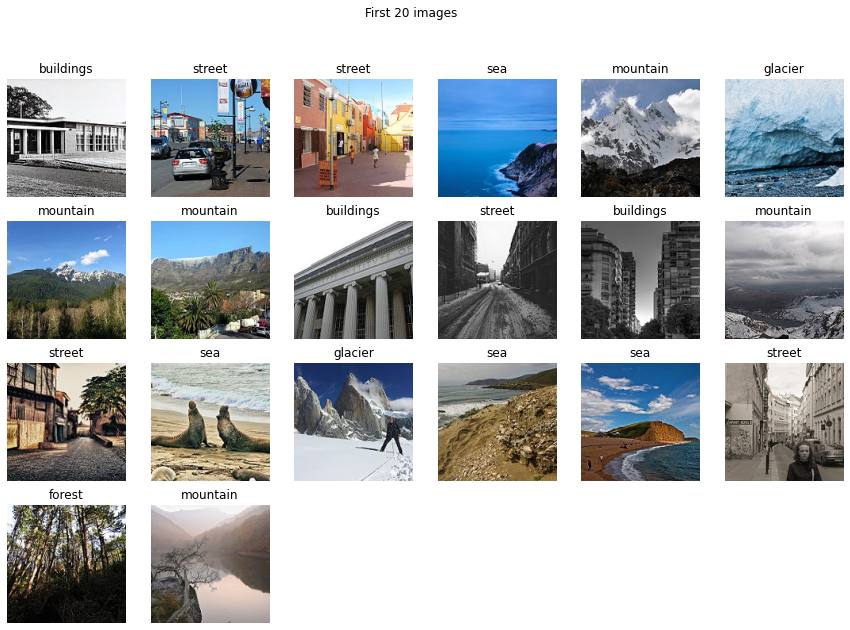

In [9]:
# let's see a few training examples!
display_images(X_train, [class_labels[np.argmax(y_train[i])] for i in range (0, len(y_train))],
    num_examples = 20, images_per_row = 6)

---
Modeling

In [10]:
def evaluate_models(models, histories, X_test, class_labels):
    '''
    Uses pre-compiled, pre-fit neural network classification models and their fit histories
    to generate useful statistics
    NOTE: assumes models were compiled with metrics including 'acc'

    Parameters:
    - models (list): list of pre-compiled, pre-fit models
    - histories (list): list of model histories - should be same length as models
    - X_test (array): test data of appropriate shape to make predictions on
    - class_labels (list): list of all possible class labels

    Displays:
    - Plots of confusion matrix, train/val loss over epochs, and test prediction counts

    Returns:c
    - DataFrame containing model name, train/validation loss, train/validation accuracy
    '''

    assert type(models) == list
    assert type(histories) == list

    num_models = len(models)
    assert len(histories) == num_models

    model_stats = pd.DataFrame(columns = ['model_name', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])

    fig = plt.figure(figsize = (20, num_models * 5.2))
    subfigs = fig.subfigures(num_models, wspace = 0.2, hspace = 0.2)
    if num_models == 1:
        subfigs = [subfigs]

    for i, model in enumerate(models):
        model_name = f'model {i}'

        train_loss = histories[i].history['loss']
        val_loss = histories[i].history['val_loss']
        train_acc = histories[i].history['acc']
        val_acc = histories[i].history['val_acc']

        # append our values to the stats dataframe
        model_stats.loc[len(model_stats)] = [model_name, train_loss[-1], val_loss[-1], train_acc[-1], val_acc[-1]]

        # display metrics
        # https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot
        subfigs[i].suptitle(model_name)
        axs = subfigs[i].subplots(1, 3)

        # confusion matrix
        val_preds = np.array([np.argmax(x) for x in model.predict(X_val, verbose = 0)]).reshape(-1)
        true_preds = np.array([np.argmax(x) for x in y_val]).reshape(-1)
        axs[0].set_title('Confusion Matrix on Validation Set')
        ConfusionMatrixDisplay.from_predictions(true_preds, val_preds, display_labels = class_labels, ax = axs[0], xticks_rotation = 45)

        # performance of train vs val
        
        epoch_labels = histories[i].epoch
        axs[1].set_title(f'Loss by Epoch - Training vs. Validation')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel(model.loss)
        axs[1].set_xticks(epoch_labels, epoch_labels)
        axs[1].plot(train_loss, label = 'Training Loss', color = '#185fad')
        axs[1].plot(val_loss, label = 'Validation Loss', color = 'orange')
        axs[1].legend()
        
        # overview of test predictions
        test_class_probs = model.predict(X_test, verbose = 0)
        test_preds = [np.argmax(x) for x in test_class_probs]
        preds_df = pd.DataFrame([[class_labels[x], test_preds.count(x)]
            for x in set(test_preds)], columns = ['article', 'test_pred_count']).set_index('article')
        axs[2].set_title(f'Test Prediction Counts')
        preds_df.plot.barh(ax = axs[2])
        axs[2].get_legend().remove()

    return model_stats
        

In [11]:
# make a list of models and a list of histories
models = []
histories = []

In [16]:
# model 0
# very simple CNN
model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(6, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 0, validation_data = (X_val, y_val))

models.append(model)
histories.append(history)

,model_name,train_loss,val_loss,train_acc,val_acc
0,model 0,0.127903,0.889457,0.972567,0.724


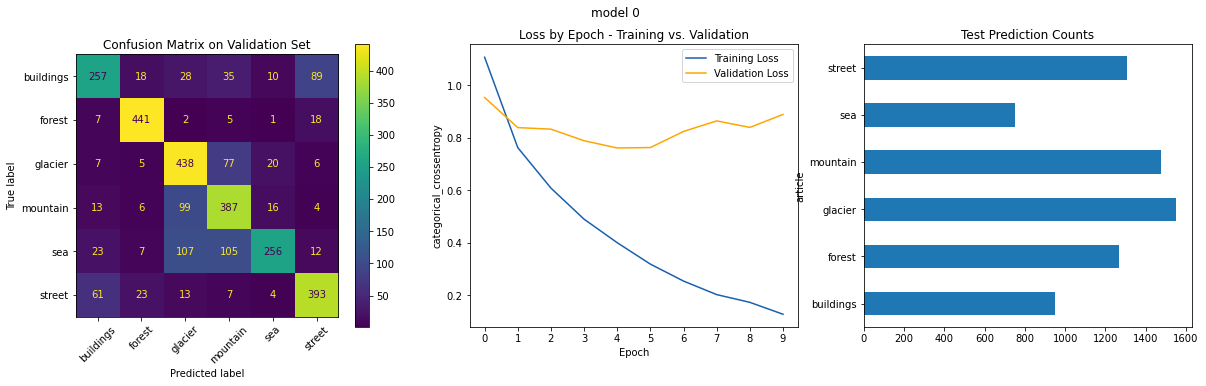

In [23]:
# let's see how we're doing so far!
evaluate_models([models[0]], [histories[0]], X_test, class_labels)

In [21]:
stats

,model_name,train_loss,val_loss,train_acc,val_acc
0,model 0,0.127903,0.889457,0.972567,0.724
1,model 1,0.623900,0.949126,0.777968,0.645


---
Model 2

In [42]:
# model_2 0
# added filters
model_2 = Sequential()
model_2.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model_2.add(MaxPooling2D(pool_size = (2, 2)))
model_2.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model_2.add(MaxPooling2D(pool_size = (2, 2)))
model_2.add(Flatten())
model_2.add(Dense(32, activation = 'relu'))
model_2.add(Dense(6, activation = 'softmax'))

model_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model_2.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 0, validation_data = (X_val, y_val))

models.append(model_2)
histories.append(history)

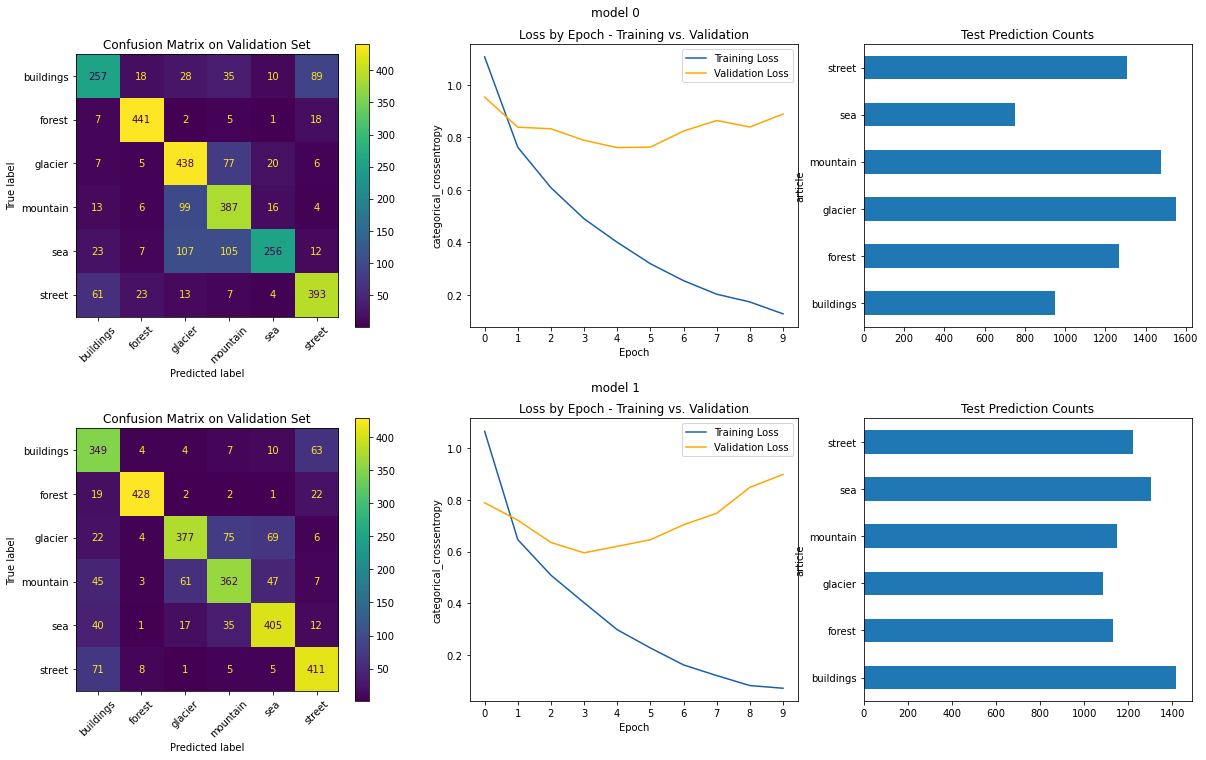

In [43]:
stats = evaluate_models(models, histories, X_test, class_labels)

In [44]:
stats

,model_name,train_loss,val_loss,train_acc,val_acc
0,model 0,0.127903,0.889457,0.972567,0.724000
1,model 1,0.071462,0.899478,0.983540,0.777333


In [52]:
# model_3 0
# added kernal_regularization
model_3 = Sequential()
model_3.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model_3.add(MaxPooling2D(pool_size = (2, 2)))
model_3.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (150, 150, 3), kernel_regularizer=l2(0.00005)))
model_3.add(MaxPooling2D(pool_size = (2, 2)))
model_3.add(Flatten())
model_3.add(Dense(32, activation = 'relu'))
model_3.add(Dense(6, activation = 'softmax'))

model_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model_3.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 0, validation_data = (X_val, y_val))

models.append(model_3)
histories.append(history)

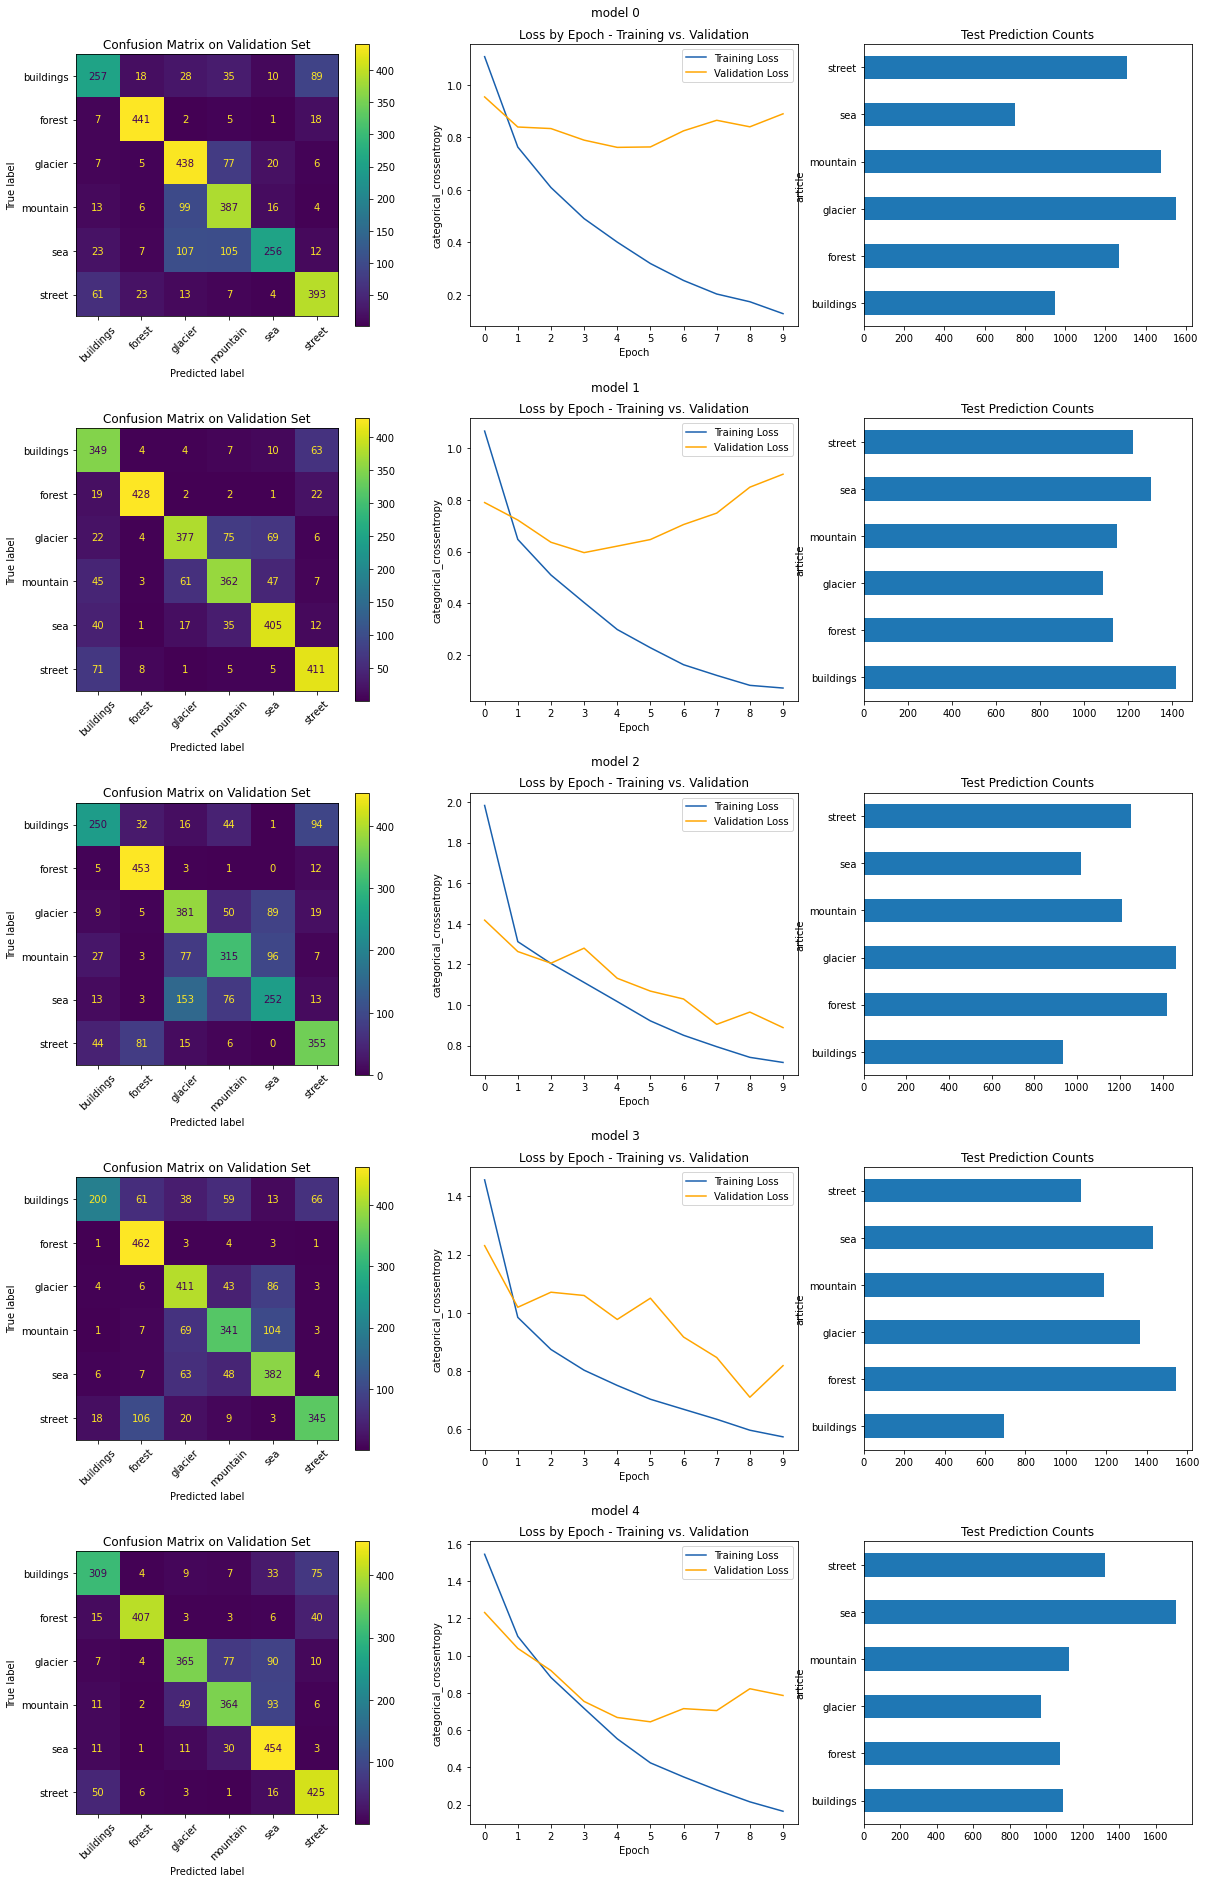

In [53]:
stats = evaluate_models(models, histories, X_test, class_labels)

In [54]:
stats

,model_name,train_loss,val_loss,train_acc,val_acc
0,model 0,0.127903,0.889457,0.972567,0.724000
1,model 1,0.071462,0.899478,0.983540,0.777333
2,model 2,0.717044,0.888742,0.724669,0.668667
3,model 3,0.572946,0.817806,0.789012,0.713667
4,model 4,0.164134,0.785713,0.954254,0.774667


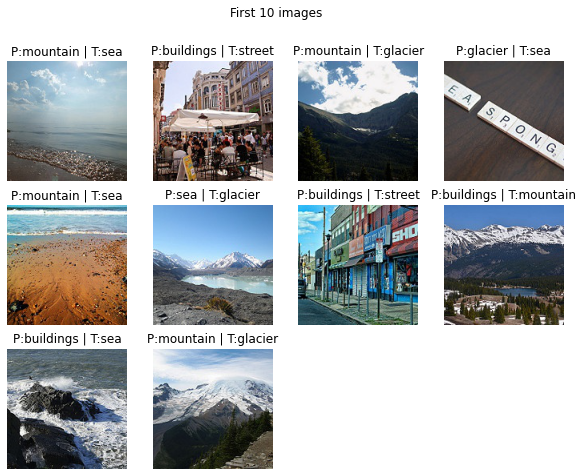

In [56]:
# just for fun, let's sample some of the confusion for the first model's validation set
# P indicates prediction, T indicates true value
val_preds = np.array([np.argmax(x) for x in models[1].predict(X_val, verbose = 0)]).reshape(-1)
true_preds = np.array([np.argmax(x) for x in y_val]).reshape(-1)
mismatches = [i for i in range(0, len(val_preds)) if val_preds[i] != true_preds[i]]
display_images([X_val[i] for i in mismatches], [f'P:{class_labels[val_preds[i]]} | T:{class_labels[true_preds[i]]}' for i in mismatches])

In [58]:
# model_4 0
# added Average pooling
model_4 = Sequential()
model_4.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model_4.add(AveragePooling2D(pool_size = (2, 2)))
model_4.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (150, 150, 3), kernel_regularizer=l2(0.00005)))
model_4.add(AveragePooling2D(pool_size = (2, 2)))
model_4.add(Flatten())
model_4.add(Dense(32, activation = 'relu'))
model_4.add(Dense(6, activation = 'softmax'))

model_4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model_4.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 0, validation_data = (X_val, y_val))

models.append(model_4)
histories.append(history)

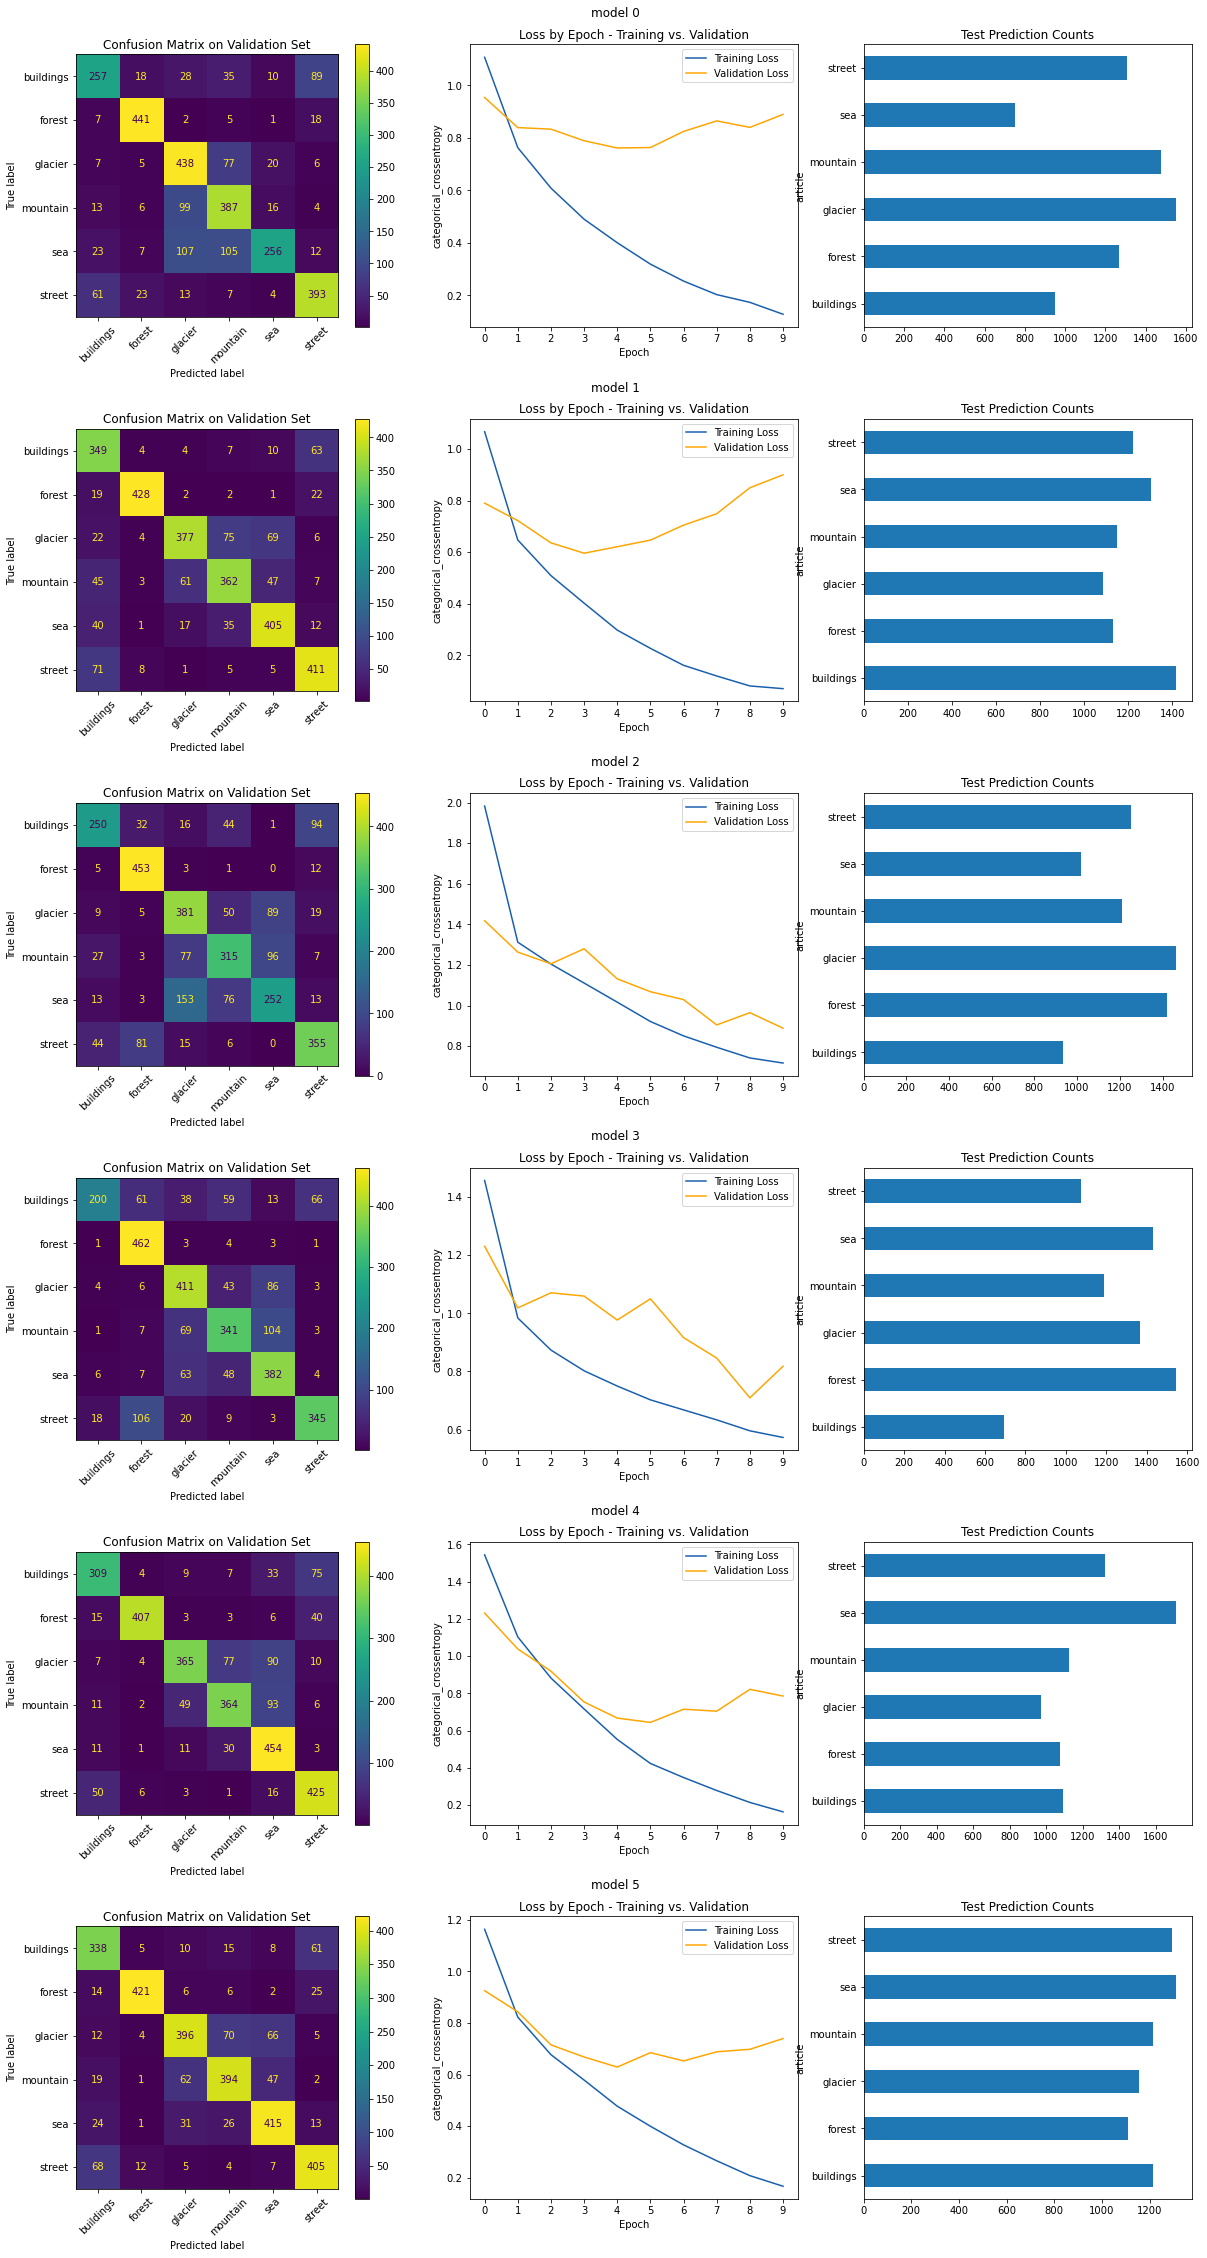

In [59]:
stats = evaluate_models(models, histories, X_test, class_labels)

In [60]:
stats

,model_name,train_loss,val_loss,train_acc,val_acc
0,model 0,0.127903,0.889457,0.972567,0.724000
1,model 1,0.071462,0.899478,0.983540,0.777333
2,model 2,0.717044,0.888742,0.724669,0.668667
3,model 3,0.572946,0.817806,0.789012,0.713667
4,model 4,0.164134,0.785713,0.954254,0.774667
5,model 5,0.167553,0.739907,0.951261,0.789667


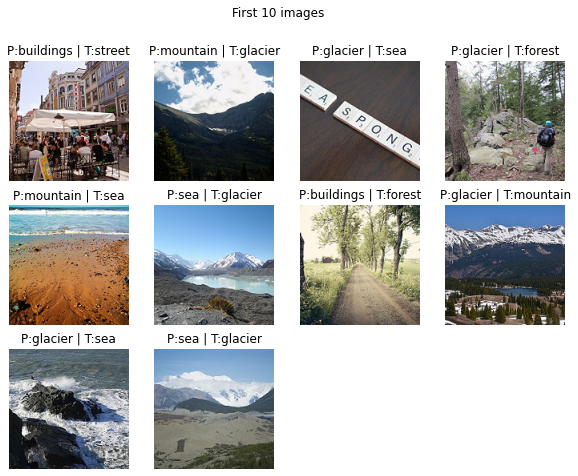

In [61]:
# just for fun, let's sample some of the confusion for the first model's validation set
# P indicates prediction, T indicates true value
val_preds = np.array([np.argmax(x) for x in models[5].predict(X_val, verbose = 0)]).reshape(-1)
true_preds = np.array([np.argmax(x) for x in y_val]).reshape(-1)
mismatches = [i for i in range(0, len(val_preds)) if val_preds[i] != true_preds[i]]
display_images([X_val[i] for i in mismatches], [f'P:{class_labels[val_preds[i]]} | T:{class_labels[true_preds[i]]}' for i in mismatches])